<a href="https://colab.research.google.com/github/Arisan24/python_data_analysis_ohmsha/blob/master/SweepFourGraphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Created by Ritsu Katayama
# Edited on 230513 Arisa Nishimura
# YOU CAN ONLY USE THIS FOR THE 10TH TRIAL OF THE 'Sweep' SETUP
# code to show the four different graphs of the 10th trial
# import depedencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import math
from pathlib import Path
import os
import matplotlib.ticker as ticker
import seaborn as sns

#from scipy import stats

# set matplotlib preferences
from matplotlib.ticker import FuncFormatter, FormatStrFormatter

In [ ]:
#YOU CAN DICTATE THE FOLDER YOU WANT TO ACCESS
#current_directory = os.getcwd()
#print("Current Directory:", current_directory)
# Prompt the user to enter the path to the folder
root = input("Enter the path to the folder you want to access: ")
# Use the folder_path variable in your code
print("Folder Path:", root)

Enter the path to the folder you want to access: /content/drive/MyDrive/0biosensor/data/230801
Folder Path: /content/drive/MyDrive/0biosensor/data/230801


In [ ]:
#Select files with 'sweep' and '(10)' and make a list
root_folder = Path(root)
file_filter = '*Sweep*(10)*.csv'
file_path_list = list(root_folder.glob(file_filter))

In [ ]:
# configure mpl rcParams
plt.rcdefaults
sns.set_style('whitegrid')
#plt.style.use('seaborn-bright')

my_rcParams = {
            # set font to use for figures
            "font.family": "sans-serif",
            "font.serif": "Arial",
            # set fontsizes
            "figure.titlesize": 10,
            "axes.titlesize": 10,
            "axes.labelsize": 10,
            "font.size": 10,
            "legend.fontsize": 7,
            "xtick.labelsize": 8,
            "ytick.labelsize": 8,
            # set some tick options
            "xtick.major.size": 3,
            "ytick.major.size": 3,
            "xtick.direction": "in",
            "ytick.direction": "in",
            "xtick.top": True,
            "ytick.right": True,
            # adjust sizes of figure objects, etc..
            "legend.frameon": False,
            "lines.linewidth": 1.5,
            "lines.markersize": 3
}

plt.rcParams.update(my_rcParams)

In [ ]:
# some parameters fixed for the setup:I_V Sweep
#左なら229#右なら260
data_header = 260
exp_name = 'ITO-TFT_IdVg'

In [ ]:
# load in the data files with pandas
roundtrip_tuple_pandas_list = []#pandasで読み込むcsvデータ
csv_path_list = []#csvファイル名

In [ ]:
#determine the scaling for value between 1 and 1e-12
#
def Axis_Scale_Determination(pandas_data, column_name, Feature_alphabet_with_apostrophe, value=1, precision=0):
    max_value = max(abs(pandas_data[column_name]))
    if max_value >= 1:
        unit = Feature_alphabet_with_apostrophe
        scaled_value = value
    elif max_value >= 0.001:
        unit = "m" + Feature_alphabet_with_apostrophe
        scaled_value = value * 1e3
    elif max_value >= 0.000001:
        unit = "μ" + Feature_alphabet_with_apostrophe
        scaled_value = value * 1e6
    elif max_value >= 1e-9:
        unit = "n" + Feature_alphabet_with_apostrophe
        scaled_value = value * 1e9
    elif max_value >= 1e-12:
        unit = "p" + Feature_alphabet_with_apostrophe
        scaled_value = value * 1e12
    else:
        print("value is smaller than pA")
    return scaled_value, unit

In [ ]:
class ScaleFormatter(ticker.Formatter):
    def __init__(self, pandas_data, column_name_with_apostrophe, unit_alphabet_with_apostrophe, number_of_digits_after_the_decimal_point):
        #CurrentFormatter(入れたいpandasのdata)とすると、self.dataという属性として登録される
        self.data = pandas_data
        self.column_name = column_name_with_apostrophe
        self.normal_unit_name = unit_alphabet_with_apostrophe
        self.precision = number_of_digits_after_the_decimal_point

    def __call__(self, value, pos):
        # Determine the appropriate scale based on the maximum value in the data
        scaled_value, I_unit = Axis_Scale_Determination(self.data, self.column_name, self.normal_unit_name, value, self.precision)
        # Format the label with the scaled value and unit
        #For example, if scaled_value is 0.12345, it will be formatted as "0.12".
        #{unit}: This part simply includes the value of the unit variable in the string.
        #f"{}" transforms objects in the blakets into string.
        return f"{scaled_value:.{self.precision}f}"

In [ ]:
# load in the data files with pandas
roundtrip_tuple_pandas_list = []#pandasで読み込むcsvデータ
csv_path_list = []#csvファイル名
for file_path in file_path_list:#(10)だけのデータ本体
    csv_pandas = pd.read_csv(file_path, header=data_header, skipinitialspace=True).dropna(axis='columns')
    #pandasで読み込むcsvデータ
    csv_path = file_path #単csvのファイルpath
    leading = csv_pandas.head(len(csv_pandas)//2).reset_index(drop=True)
    trailing = csv_pandas.tail(len(csv_pandas)//2)[::-1].reset_index(drop=True)
    roundtrip_tuple_pandas = (leading, trailing) #pandasで読み込んだ単csvデータを、行き帰りで2分割してtupleに格納した

    # add a new column with calculated data
    for oneway_pandas in roundtrip_tuple_pandas:
        oneway_pandas['Gm'] = np.gradient(oneway_pandas['Id'], oneway_pandas['Vg'])

    roundtrip_tuple_pandas_list.append(roundtrip_tuple_pandas) #pandasで2分割された行き帰りtuple (いきCSV、帰りCSV)、各CSVにおけるリスト
    csv_path_list.append(csv_path) #csvファイル名のリスト

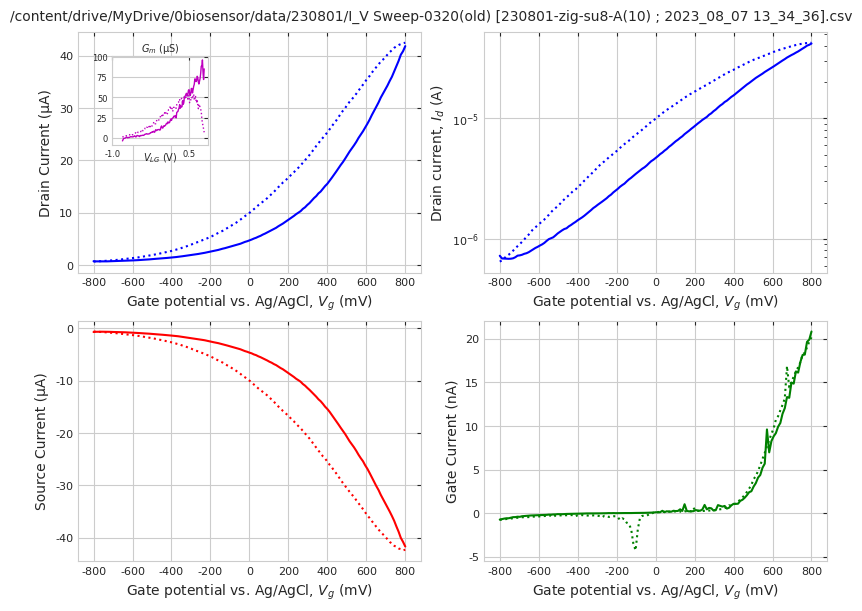

In [ ]:
#visualize data with matplotlib
fig_list_per_different_csv = []
#for data_l, data_t in data_list:
for (leading_pd, trailing_pd), csv_path in zip(roundtrip_tuple_pandas_list, csv_path_list):  #あるCVSにおける、行きのpandas、帰りのpandas、csvファイル名について
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False,
                           figsize=(8,6), constrained_layout=True)
    fig.suptitle(csv_path)

    #Calculate the scale
    Id_scaled_value, Id_unit = Axis_Scale_Determination(leading_pd, 'Id', 'A')
    Id_axis_unit = Id_unit
    Id_scale = ScaleFormatter(leading_pd, 'Id', 'A', 0)

    Is_scaled_value, Is_unit = Axis_Scale_Determination(leading_pd, 'Is', 'A')
    Is_axis_unit = Is_unit
    Is_scale = ScaleFormatter(leading_pd, 'Is', 'A', 0)

    Vg_scaled_value, Vg_unit = Axis_Scale_Determination(leading_pd, 'Vg', 'V')
    Vg_axis_unit = Vg_unit
    Vg_scale = ScaleFormatter(leading_pd, 'Vg', 'V', 0)

    V_new_scale = FuncFormatter(lambda x, p: '{:.0f}'.format(x*1e3))

    Gm_scaled_value, Gm_unit = Axis_Scale_Determination(leading_pd, 'Gm', 'S')
    Gm_axis_unit = Gm_unit
    Gm_scale = ScaleFormatter(leading_pd, 'Gm', 'S', 0)

    Gm_V_scale = FormatStrFormatter('%.1f')

    Ig_scaled_value, Ig_unit = Axis_Scale_Determination(leading_pd, 'Ig', 'A')
    Ig_axis_unit = Ig_unit
    Ig_scale = ScaleFormatter(leading_pd, 'Ig', 'A', 0)


    # TL plot [0,0] is Id-Vg
    ax[0, 0].plot(leading_pd['Vg'], leading_pd['Id'], 'b-')
    ax[0, 0].plot(trailing_pd['Vg'], trailing_pd['Id'], 'b:')
    #ax[0,0].set_ylim([-10e-6, 210e-6])
    #ax[0,0].set_xlim([-1.05, 0.55])

    #ax[0,0].yaxis.set_major_formatter(I_scale)
    #ax[0,0].xaxis.set_major_formatter(V_scale)

    #ax.set_yscale('log')
    ax[0,0].yaxis.set_major_formatter(Id_scale)
    ax[0,0].set_ylabel('Drain Current ({})'.format(Id_axis_unit))

    ax[0,0].xaxis.set_major_formatter(V_new_scale)
    ax[0,0].set_xlabel('Gate potential vs. Ag/AgCl, $V_{g}$ (mV)')


    # # inset in TL plot
    ax_in = ax[0,0].inset_axes([0.1,0.53,0.28,0.37])#[0.17,0.65,0.28,0.32])
    #ax_in.set_ylabel('$G_m$ ({})'.format(Gm_axis_unit))
    ax_in.set_title(f'$G_m$ ({Gm_axis_unit})', fontsize=7, pad=3)
    #ax_in.set_title('$G_m$ ($\mu$S)', fontsize=7, pad=3)
    ax_in.plot(leading_pd['Vg'], leading_pd['Gm'], 'm-', linewidth=1)
    ax_in.plot(trailing_pd['Vg'], trailing_pd['Gm'], 'm:', linewidth=1)

    ax_in.yaxis.set_major_formatter(Gm_scale)
    ax_in.xaxis.set_major_formatter(Gm_V_scale)
    ax_in.set_xlabel('$V_{LG}$ (V)', fontsize=7, labelpad=-6)
    ax_in.set_xticks([-1, 0.5])
    ax_in.tick_params(axis='both', labelsize=6)

    # TR plot [0,1] is log(Id)-Vg
    ax[0,1].plot(leading_pd['Vg'], leading_pd['Id'], 'b-')
    ax[0,1].plot(trailing_pd['Vg'], trailing_pd['Id'], 'b:')

    ax[0,1].set_yscale('log')
    #ax[0,1].set_xlim([-1.05, 0.55])

    #ax[0,1].yaxis.set_major_formatter(I_scale)
    ax[0,1].xaxis.set_major_formatter(V_new_scale)

    ax[0,1].set_ylabel('Drain current, $I_d$ (A)')
    ax[0,1].set_xlabel('Gate potential vs. Ag/AgCl, $V_{g}$ (mV)')

    # BL plot [1,0] is Is-Vg
    ax[1,0].plot(leading_pd['Vg'], leading_pd['Is'], 'r-')
    ax[1,0].plot(trailing_pd['Vg'], trailing_pd['Is'], 'r:')

    #ax[1,0].set_ylim([-210e-6, 10e-6])
    #ax[1,0].set_xlim([-1.05, 0.55])

    ax[1,0].yaxis.set_major_formatter(Is_scale)
    ax[1,0].xaxis.set_major_formatter(V_new_scale)
    ax[1,0].set_ylabel('Source Current ({})'.format(Is_axis_unit))
    ax[1,0].set_xlabel('Gate potential vs. Ag/AgCl, $V_{g}$ (mV)')

    # BR plot [1,1] is Ig-Vg
    ax[1,1].plot(leading_pd['Vg'], leading_pd['Ig'], 'g-')
    ax[1,1].plot(trailing_pd['Vg'], trailing_pd['Ig'], 'g:')

    #ax[1,1].set_ylim([-12e-6, 27e-6])
    #ax[1,1].set_xlim([-1.05, 0.55])

    ax[1,1].yaxis.set_major_formatter(Ig_scale)
    ax[1,1].xaxis.set_major_formatter(V_new_scale)

    ax[1,1].set_ylabel('Gate Current ({})'.format(Ig_axis_unit))
    ax[1,1].set_xlabel('Gate potential vs. Ag/AgCl, $V_{g}$ (mV)')

    fig_list_per_different_csv.append(fig)




